This notebook is part of my [Python data science curriculum](http://www.terran.us/articles/python_curriculum.html)

There are two major sets of documentation which are relevant for H2O:

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html  
http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html


In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Cluster Init

In [2]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_111"; OpenJDK Runtime Environment (build 1.8.0_111-8u111-b14-2~bpo8+1-b14); OpenJDK 64-Bit Server VM (build 25.111-b14, mixed mode)
  Starting server from /opt/pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpz21aee3a
  JVM stdout: /tmp/tmpz21aee3a/h2o_terran_started_from_python.out
  JVM stderr: /tmp/tmpz21aee3a/h2o_terran_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,"21 days, 13 hours and 13 minutes"
H2O cluster name:,H2O_from_python_terran_lnzuev
H2O cluster total nodes:,1
H2O cluster free memory:,10.50 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


# Data Loading

At first I thought you could only load from disk:

In [3]:
from plotnine.data import diamonds
diamonds.to_csv('/tmp/diamonds.csv')
h2o_diamonds = h2o.import_file('/tmp/diamonds.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


But in fact you __can__ transfer data from Python.  The key piece of information is that you use the h2o.H2OFrame __constructor__ to do it.  See references:

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/data.html#loading-data-from-a-python-object  
http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#h2oframe  

In [4]:
# The destination_frame argument is optional, but if you don't use it, you get a horrible hex name.
h2o_diamonds2 = h2o.H2OFrame(diamonds, destination_frame='diamonds2')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
h2o.ls()

,key
0,diamonds.hex
1,diamonds2


In [6]:
h2o_diamonds2

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.2,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48
0.24,Very Good,I,VVS1,62.3,57,336,3.95,3.98,2.47
0.26,Very Good,H,SI1,61.9,55,337,4.07,4.11,2.53
0.22,Fair,E,VS2,65.1,61,337,3.87,3.78,2.49
0.23,Very Good,H,VS1,59.4,61,338,4,4.05,2.39


# Linear Regression

## Failed Attempt

Let's fit a very simple model:

In [7]:
h2o_lm = h2o.estimators.H2OGeneralizedLinearEstimator(family='gaussian')

In [8]:
h2o_lm.train(x=['carat','cut','color','clarity'],y='price',training_frame=h2o_diamonds2)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
h2o_lm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1544750361877_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 10733609.79576042
RMSE: 3276.2188259883405
MAE: 2430.585433525635
RMSLE: 0.9615249847776893
R^2: 0.3255806286420655
Mean Residual Deviance: 10733609.79576042
Null degrees of freedom: 53939
Residual degrees of freedom: 53919
Null deviance: 858473135517.3629
Residual deviance: 578970912383.317
AIC: 1026347.841393112
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-13 20:19:30,0.000 sec,0,858473135517.3977051,15915334.3625769


__This is not right at all.  $R^2$ should be 0.91 for this model, not 0.35!__

__Aha, it appears the default model is regularized.__  This is not explicitly stated but it is implied by the available arguments.

## Successful Attempt

In [10]:
# Note the lambda_=0 to turn off regularization
h2o_lm = h2o.estimators.H2OGeneralizedLinearEstimator(family='gaussian',lambda_=0)
h2o_lm.train(x=['carat','cut','color','clarity'],y='price',training_frame=h2o_diamonds2)
h2o_lm

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1544750361877_2


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1337834.1891373708
RMSE: 1156.6478241614302
MAE: 803.6533760003574
RMSLE: NaN
R^2: 0.9159405540179452
Mean Residual Deviance: 1337834.1891373708
Null degrees of freedom: 53939
Residual degrees of freedom: 53921
Null deviance: 858473135517.3629
Residual deviance: 72162776162.06978
AIC: 914023.0749361591
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-13 20:19:31,0.000 sec,0,858473135517.3977051,15915334.3625769


That's more like it!

In [11]:
h2o_lm.coef()

{'Intercept': -7362.802156302129,
 'clarity.IF': 5419.646844614482,
 'clarity.SI1': 3573.6879873533635,
 'clarity.SI2': 2625.949986564772,
 'clarity.VS1': 4534.878969577319,
 'clarity.VS2': 4217.829101987275,
 'clarity.VVS1': 5072.027644985769,
 'clarity.VVS2': 4967.199410006727,
 'color.E': -211.68248136947267,
 'color.F': -303.3100325817252,
 'color.G': -506.1995360406308,
 'color.H': -978.697664842068,
 'color.I': -1440.301901907411,
 'color.J': -2325.2223602461086,
 'cut.Good': 655.7674482639526,
 'cut.Ideal': 998.254438325935,
 'cut.Premium': 869.3959030779079,
 'cut.Very Good': 848.7168776837254,
 'carat': 8886.128882503353}

In [12]:
h2o.ls()

,key
0,GLM_model_python_1544750361877_1
1,GLM_model_python_1544750361877_2
2,diamonds.hex
3,diamonds2
4,modelmetrics_GLM_model_python_1544750361877_1@...
5,modelmetrics_GLM_model_python_1544750361877_2@...


# Random Forest

In [13]:
h2o_rf = h2o.estimators.random_forest.H2ORandomForestEstimator()
h2o_rf.train(x=['carat','cut','color','clarity'],y='price',training_frame=h2o_diamonds2)
h2o_rf


drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1544750361877_3


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2079779.0992632748
RMSE: 1442.143924600896
MAE: 966.3844774489775
RMSLE: 0.5464101031548934
Mean Residual Deviance: 2079779.0992632748
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-12-13 20:19:31,0.099 sec,0.0,nan,nan,nan
,2018-12-13 20:19:32,0.599 sec,1.0,1572.8323757,936.4122636,2473801.6821759
,2018-12-13 20:19:32,0.750 sec,2.0,1511.6251593,980.5250812,2285010.6223487
,2018-12-13 20:19:32,0.861 sec,3.0,1689.9269547,1047.6371095,2855853.1122827
,2018-12-13 20:19:32,1.000 sec,4.0,1492.0456369,896.8322222,2226200.1827169
---,---,---,---,---,---,---
,2018-12-13 20:19:34,2.717 sec,46.0,1440.3415218,966.2892714,2074583.6993443
,2018-12-13 20:19:34,2.741 sec,47.0,1462.3473237,981.7449913,2138459.6951667
,2018-12-13 20:19:34,2.766 sec,48.0,1465.3928902,983.4891060,2147376.3225565
,2018-12-13 20:19:34,2.796 sec,49.0,1447.4702824,972.0903774,2095170.2184324



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
carat,18256318431232.0000000,1.0,0.9027340
clarity,931802841088.0000000,0.0510400,0.0460756
color,737371488256.0000000,0.0403899,0.0364614
cut,297871540224.0000000,0.0163161,0.0147291


In [14]:
h2o_rf.varimp()

[('carat', 18256318431232.0, 1.0, 0.9027339941905617),
 ('clarity', 931802841088.0, 0.05104001908149883, 0.04607556028900392),
 ('color', 737371488256.0, 0.04038993354731048, 0.03646136603625495),
 ('cut', 297871540224.0, 0.01631607935334959, 0.014729079484179432)]

# Gradient Boosting

We will split the data into training and test, use cross-validation on the training data to tune the hyperparameters, and then evaluate on the test data.  This is a standard workflow for high-variance ML models.

First split the data

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/splitting-datasets.html

In [15]:
diamonds_split = h2o_diamonds2.split_frame(ratios=[0.75], destination_frames=['diamonds_train','diamonds_test'])

In [16]:
diamonds_split[0].dim

[40444, 10]

Then fit a model with cross-validation by specifying nfolds  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [17]:
h2o_gb = h2o.estimators.gbm.H2OGradientBoostingEstimator(nfolds=5)                                                       

In [18]:
h2o_gb.train(x=['carat','cut','color','clarity'],y='price',training_frame=diamonds_split[0])

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
h2o_gb

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1544750361877_4


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 291289.0591014654
RMSE: 539.7120149685992
MAE: 291.15811039439154
RMSLE: 0.11403758077295047
Mean Residual Deviance: 291289.0591014654

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 318952.6407328581
RMSE: 564.7589226677682
MAE: 300.514499690523
RMSLE: 0.11638301817429214
Mean Residual Deviance: 318952.6407328581
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,300.5128,3.677444,306.593,302.6331,299.6562,291.09317,302.58844
mean_residual_deviance,318975.66,9070.769,337070.2,326859.25,310532.75,300005.06,320411.0
mse,318975.66,9070.769,337070.2,326859.25,310532.75,300005.06,320411.0
r2,0.9800078,0.0004752,0.9794658,0.9795043,0.9807221,0.9809305,0.9794166
residual_deviance,318975.66,9070.769,337070.2,326859.25,310532.75,300005.06,320411.0
rmse,564.6648,8.041395,580.57745,571.71606,557.25464,547.7272,566.0486
rmsle,0.1163747,0.0008166,0.1151984,0.1153711,0.1163005,0.1165711,0.1184322


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-12-13 20:19:43,6.711 sec,0.0,3994.3964930,3033.6648252,15955203.3430623
,2018-12-13 20:19:43,6.769 sec,1.0,3619.8152636,2739.5361668,13103062.5423542
,2018-12-13 20:19:43,6.827 sec,2.0,3283.5998197,2476.0971627,10782027.7762236
,2018-12-13 20:19:43,6.884 sec,3.0,2983.6510957,2238.4966037,8902173.8607495
,2018-12-13 20:19:43,6.928 sec,4.0,2715.2776594,2026.2305075,7372732.7677644
---,---,---,---,---,---,---
,2018-12-13 20:19:44,7.437 sec,46.0,547.1342616,296.8247327,299355.9001715
,2018-12-13 20:19:44,7.449 sec,47.0,544.7315694,295.1905176,296732.4826661
,2018-12-13 20:19:44,7.460 sec,48.0,543.2680914,293.7298975,295140.2191057
,2018-12-13 20:19:44,7.470 sec,49.0,541.3042959,292.4713330,293010.3407167



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
carat,2981761384448.0000000,1.0,0.8942768
clarity,226965176320.0000000,0.0761178,0.0680704
color,115138985984.0000000,0.0386144,0.0345320
cut,10405691392.0000000,0.0034898,0.0031208


That didn't print well; let's try this instead:

In [20]:
h2o_gb.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,300.5128,3.677444,306.593,302.6331,299.6562,291.09317,302.58844
1,mean_residual_deviance,318975.66,9070.769,337070.2,326859.25,310532.75,300005.06,320411.0
2,mse,318975.66,9070.769,337070.2,326859.25,310532.75,300005.06,320411.0
3,r2,0.9800078,4.7522815E-4,0.9794658,0.9795043,0.9807221,0.98093045,0.97941655
4,residual_deviance,318975.66,9070.769,337070.2,326859.25,310532.75,300005.06,320411.0
5,rmse,564.6648,8.041395,580.57745,571.71606,557.25464,547.7272,566.0486
6,rmsle,0.11637469,8.165836E-4,0.11519845,0.115371145,0.11630051,0.116571106,0.11843221


In [21]:
results=pd.DataFrame()
for lr in [0.02,.05,0.1,0.2,0.5]:
    for ntrees in [5,50,500]:
        h2o_gb = h2o.estimators.gbm.H2OGradientBoostingEstimator(nfolds=5,learn_rate=lr,ntrees=ntrees)
        h2o_gb.train(x=['carat','cut','color','clarity','x','y','z','depth','table'],y='price',training_frame=diamonds_split[0])
        tmp=h2o_gb.cross_validation_metrics_summary().as_data_frame()
        tmp['lr']=lr
        tmp['ntrees']=ntrees
        results=pd.concat([results,tmp])
    

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |█

In [22]:
tmp=results[lambda x: x.iloc[:,0]=='rmse'].copy()
# For some reason all the data is strings
tmp['mean']=tmp['mean'].astype('double')

tmp.sort_values('mean').head()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,lr,ntrees
5,rmse,531.83060,10.007129,540.29706,535.80707,516.2322,551.65186,515.16504,0.10,500
5,rmse,531.89950,7.004916,533.2855,548.17737,533.898,518.42834,525.70825,0.05,500
5,rmse,540.66590,3.400645,546.65967,545.441,540.56244,535.2106,535.45575,0.02,500
5,rmse,546.05880,11.197579,538.4264,552.35156,547.7864,521.8549,569.87463,0.20,500
5,rmse,550.65186,14.800012,583.1655,560.83276,547.0235,542.37396,519.86346,0.20,50


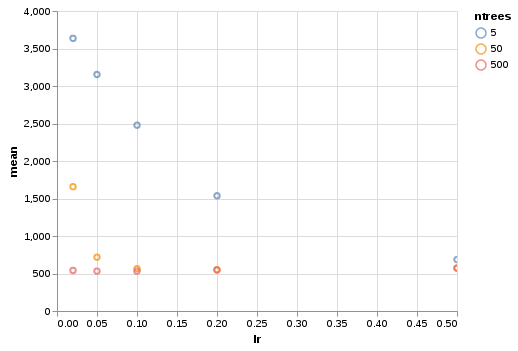

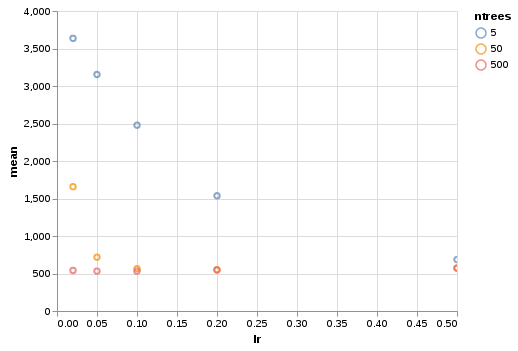

In [23]:
c=alt.Chart(tmp[tmp.iloc[:,0]=='rmse'])
c.mark_point().encode(x='lr:Q',color='ntrees:N',y='mean').interactive()

# I didn't end up using this because it was too dense to see on the chart
#tmp['sd']=tmp['sd'].astype('double')
#tmp['low']=tmp['mean'] - 2*tmp.sd
#tmp['high']=tmp['mean'] + 2*tmp.sd


In [24]:
h2o_gb_best = h2o.estimators.gbm.H2OGradientBoostingEstimator(learn_rate=0.05,ntrees=500)
h2o_gb_best.train(
    x=['carat','cut','color','clarity','x','y','z','depth','table'],y='price',
    training_frame=diamonds_split[0],validation_frame=diamonds_split[1])
h2o_gb_best

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1544750361877_20


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 199491.27996210408
RMSE: 446.64446706760407
MAE: 245.20373751829243
RMSLE: 0.09238790883975073
Mean Residual Deviance: 199491.27996210408

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 282715.38209518313
RMSE: 531.7098664640173
MAE: 272.9169159379671
RMSLE: 0.10024026821592041
Mean Residual Deviance: 282715.38209518313
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-12-13 20:22:13,0.012 sec,0.0,3994.3964930,3033.6648252,15955203.3430623,3974.4125294,3030.7853958,15795954.9541093
,2018-12-13 20:22:13,0.046 sec,1.0,3807.5820000,2886.4265493,14497680.6866169,3788.0669152,2883.1127535,14349450.9542388
,2018-12-13 20:22:13,0.080 sec,2.0,3630.4535985,2746.4540468,13180193.3309136,3611.2379138,2742.5377061,13041039.2699111
,2018-12-13 20:22:13,0.114 sec,3.0,3461.9263567,2613.9418380,11984934.0991557,3442.9996808,2609.8667122,11854246.8019348
,2018-12-13 20:22:13,0.148 sec,4.0,3302.6116250,2488.2785488,10907243.5457967,3283.7466748,2484.0030167,10782992.2244687
---,---,---,---,---,---,---,---,---,---
,2018-12-13 20:22:17,3.911 sec,136.0,509.3181942,274.0300863,259405.0229416,548.3043298,285.9402525,300637.6381091
,2018-12-13 20:22:17,3.937 sec,137.0,508.9517086,273.7642643,259031.8416455,548.1878262,285.7466014,300509.8927846
,2018-12-13 20:22:17,3.967 sec,138.0,508.5194376,273.4900699,258592.0184162,548.0704907,285.5630409,300381.2628092
,2018-12-13 20:22:17,3.995 sec,139.0,507.9360878,273.2626132,257999.0692650,547.7861315,285.3970975,300069.6458349



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
y,3249070145536.0000000,1.0,0.4971292
carat,2369863811072.0000000,0.7293976,0.3626048
clarity,426141483008.0000000,0.1311580,0.0652025
color,226389131264.0000000,0.0696781,0.0346390
x,138247340032.0000000,0.0425498,0.0211528
z,106740916224.0000000,0.0328528,0.0163321
cut,10334444544.0000000,0.0031807,0.0015812
depth,6291180544.0000000,0.0019363,0.0009626
table,2587166464.0000000,0.0007963,0.0003959


Alternatively, you could try H2OGridSearch  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-search-example-in-python

# Predictions

We can also run the models and get the results back in Pandas objects:

In [31]:
gb_predictions=h2o_gb_best.predict(diamonds_split[1])
lm_predictions=h2o_lm.predict(diamonds_split[1])

gbm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


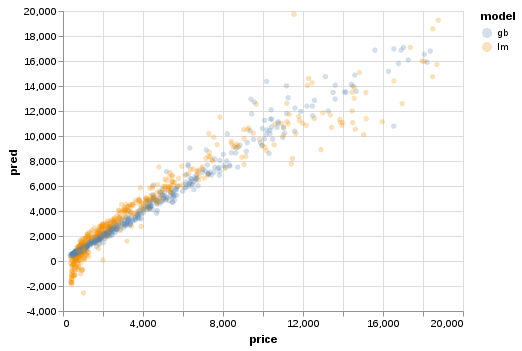

In [43]:
pred=diamonds_split[1].as_data_frame().assign(
  model='gb',pred=gb_predictions.as_data_frame()).append(
  diamonds_split[1].as_data_frame().assign(
  model='lm',pred=lm_predictions.as_data_frame())).sample(1000)
    
alt.Chart(pred).mark_circle(opacity=0.25).encode(
    x='price',y='pred',color='model'
).interactive()